ALAGNAK RIVER
TOP 10 FEATURES

Gradient Boosting Evaluation Metrics (Alagnak, Top 10 Features):
R²   (R-squared):              -2.5359
MSE  (Mean Squared Error):     5963904879861.98
MAPE (Mean Absolute % Error):  73.61%

Polynomial Regression Evaluation Metrics (Alagnak, Top 7 Features):
R²   (R-squared):              -114.1581
MSE  (Mean Squared Error):     194236294991931.22
MAPE (Mean Absolute % Error):  259.86%

Linear Regression Evaluation Metrics (Alagnak, Top 10 Features):
R²   (R-squared):              -0.9679
MSE  (Mean Squared Error):     3319289387160.84
MAPE (Mean Absolute % Error):  51.13%

Random Forest Evaluation Metrics (Alagnak, Top 10 Features):
R²   (R-squared):              -0.9224
MSE  (Mean Squared Error):     3242429195245.71
MAPE (Mean Absolute % Error):  53.73%

Random Forest with Log-Transformed Target (Alagnak, Top 10 Features):
R²   (R-squared):              -0.3405
MSE  (Mean Squared Error):     2260977569251.44
MAPE (Mean Absolute % Error):  42.83%

Random Forest + Log-Transformed Target + GridSearchCV (Alagnak, Top 8 Features):
Best Params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
R²   (R-squared):              -0.5752
MSE  (Mean Squared Error):     2656905945978.65
MAPE (Mean Absolute % Error):  46.67%

XGBoost Evaluation Metrics (Alagnak, Top 9 Features):
R²   (R-squared):              -3.8437
MSE  (Mean Squared Error):     8169792995392.21
MAPE (Mean Absolute % Error):  82.54%


GradientBoostingRegressor

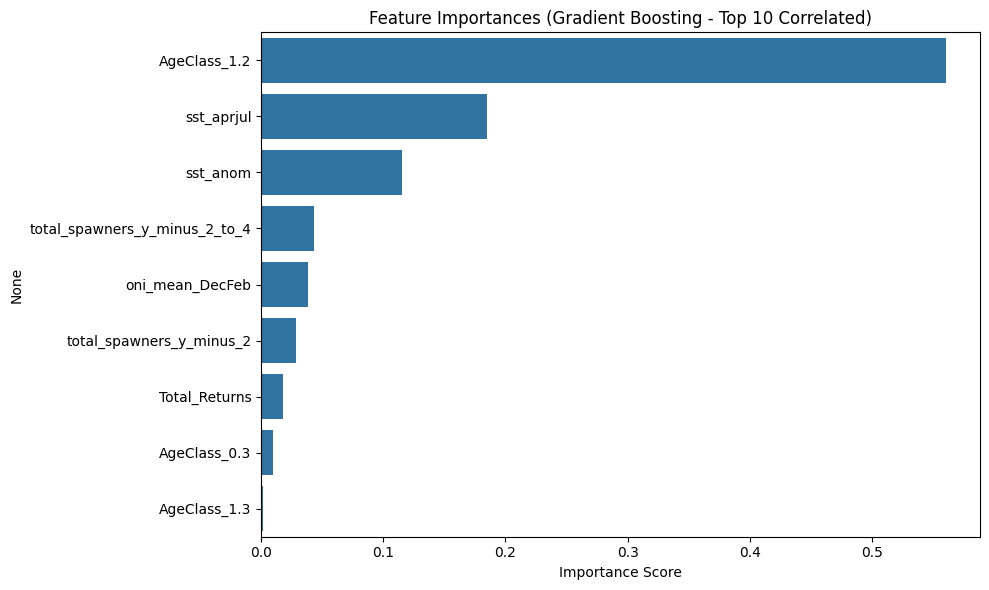

📊 Gradient Boosting Evaluation Metrics (Alagnak, Top 10 Features):
THIRD APPROACH - River Alagnak - TOP 10 FEATURES
🔹 R²   (train): 1.0000     | R²   (test): -2.5359
🔹 MSE  (train):  790957.55   | MSE  (test):  5963904879861.98
🔹 MAPE (train): 0.04%  | MAPE (test): 73.61%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Keep only rows where River is 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 10 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top10_features = target_corr.abs().sort_values(ascending=False).head(10).index.tolist()

# Ensure column order and include Year, River, Target
columns_to_keep = top10_features + [col for col in ['Total_Returns_NextYear', 'Year', 'River'] if col not in top10_features]
df_alagnak = df_alagnak[columns_to_keep].sort_values(by='Year').reset_index(drop=True)

# === Step 3: Define and apply time-based split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and target ===
drop_columns = ['Total_Returns_NextYear', 'River', 'Year']
X_train = data_train.drop(columns=drop_columns).reset_index(drop=True)
y_train = data_train['Total_Returns_NextYear'].reset_index(drop=True)
X_test = data_test.drop(columns=drop_columns).reset_index(drop=True)
y_test = data_test['Total_Returns_NextYear'].reset_index(drop=True)

# === Step 5: Train Gradient Boosting Regressor ===
gbr = GradientBoostingRegressor(
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=4, 
    random_state=42
)
gbr.fit(X_train, y_train)

# === Step 6: Feature Importances Plot ===
feature_importances = pd.Series(gbr.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Gradient Boosting - Top 10 Correlated)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate ===
y_pred_train = gbr.predict(X_train)
y_pred_test = gbr.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("📊 Gradient Boosting Evaluation Metrics (Alagnak, Top 10 Features):")
print("THIRD APPROACH - River Alagnak - TOP 10 FEATURES")
print(f"🔹 R²   (train): {r2_train:.4f}     | R²   (test): {r2_test:.4f}")
print(f"🔹 MSE  (train):  {mse_train:.2f}   | MSE  (test):  {mse_test:.2f}")
print(f"🔹 MAPE (train): {mape_train:.2f}%  | MAPE (test): {mape_test:.2f}%")

# Define result string
result_str = (
    "\n\n===============================\n"
    "THIRD APPROACH - TOP 10 FEATURES - Alagnak Only\n"
    "Gradient Boosting :\n"
    f"R²   (R-squared test):          {r2_test:.4f}\n"
    f"R²   (R-squared train):         {r2_train:.4f}\n"
    f"MSE  (Mean Squared Erro train):      {mse_train:.2f}\n"
    f"MSE  (Mean Squared Error test):      {mse_test:.2f}\n"
    f"MAPE (MAPE train):   {mape_train:.2f}%\n"
    f"MSE  (MAPE test):      {mape_test:.2f}\n"
)

# Path to results file
results_path = r"C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\results.txt"

# Append to file
with open(results_path, "a", encoding="utf-8") as f:
    f.write(result_str)


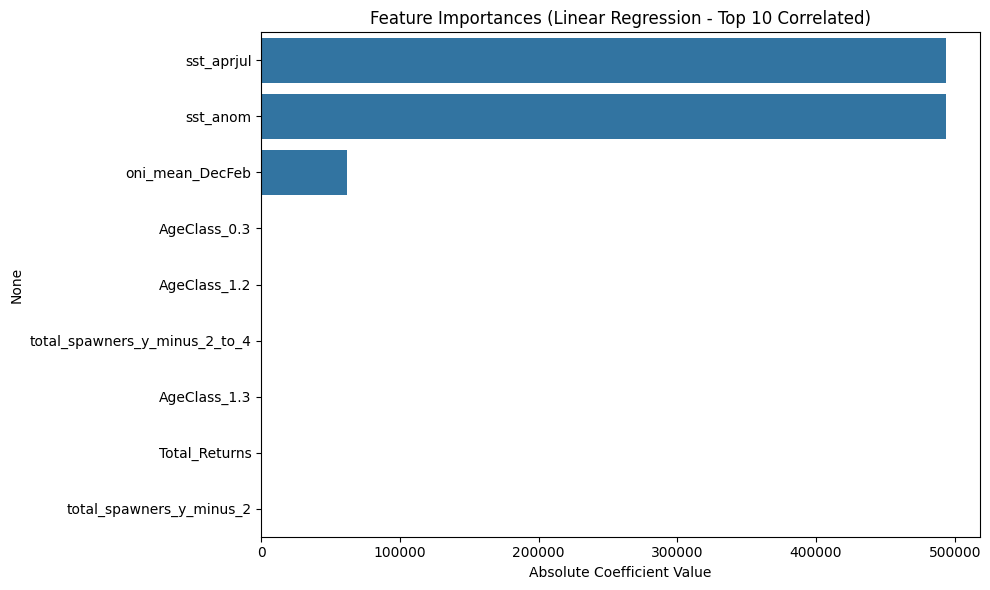

📊 Linear Regression Evaluation Metrics (Alagnak, Top 10 Features):
THIRD APPROACH - River Alagnak - TOP 10 FEATURES
🔹 R²   (train): 0.5115     | R²   (test): -0.9679
🔹 MSE  (train):  1675306344054.60   | MSE  (test):  3319289387160.84
🔹 MAPE (train): 45.11%  | MAPE (test): 51.13%


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Filter for 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 10 correlated features ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top10_features = target_corr.abs().sort_values(ascending=False).head(10).index.tolist()

# Force consistent column order and avoid duplication
columns_to_keep = top10_features + [col for col in ['Total_Returns_NextYear', 'Year', 'River'] if col not in top10_features]
df_alagnak = df_alagnak[columns_to_keep].sort_values(by='Year').reset_index(drop=True)

# === Step 3: Time-based train/test split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and target ===
drop_columns = ['Total_Returns_NextYear', 'River', 'Year']
X_train = data_train.drop(columns=drop_columns).reset_index(drop=True)
y_train = data_train['Total_Returns_NextYear'].reset_index(drop=True)
X_test = data_test.drop(columns=drop_columns).reset_index(drop=True)
y_test = data_test['Total_Returns_NextYear'].reset_index(drop=True)

# === Step 5: Train Linear Regression ===
model = LinearRegression()
model.fit(X_train, y_train)

# === Step 6: Plot Coefficients ===
coefficients = pd.Series(model.coef_, index=X_train.columns)
top_features = coefficients.abs().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Linear Regression - Top 10 Correlated)")
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate ===
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Métricas de treino
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

# Métricas de teste
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Impressão
print("📊 Linear Regression Evaluation Metrics (Alagnak, Top 10 Features):")
print("THIRD APPROACH - River Alagnak - TOP 10 FEATURES")
print(f"🔹 R²   (train): {r2_train:.4f}     | R²   (test): {r2_test:.4f}")
print(f"🔹 MSE  (train):  {mse_train:.2f}   | MSE  (test):  {mse_test:.2f}")
print(f"🔹 MAPE (train): {mape_train:.2f}%  | MAPE (test): {mape_test:.2f}%")

# Define result string
result_str = (
    "\n\n===============================\n"
    "THIRD APPROACH - TOP 10 FEATURES - Alagnak Only\n"
    "Linear Regression :\n"
    f"R²   (R-squared test):          {r2_test:.4f}\n"
    f"R²   (R-squared train):         {r2_train:.4f}\n"
    f"MSE  (Mean Squared Erro train):      {mse_train:.2f}\n"
    f"MSE  (Mean Squared Error test):      {mse_test:.2f}\n"
    f"MAPE (MAPE train):   {mape_train:.2f}%\n"
    f"MSE  (MAPE test):      {mape_test:.2f}\n"
)

# Path to results file
results_path = r"C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\results.txt"

# Append to file
with open(results_path, "a", encoding="utf-8") as f:
    f.write(result_str)


Polynomial Regression

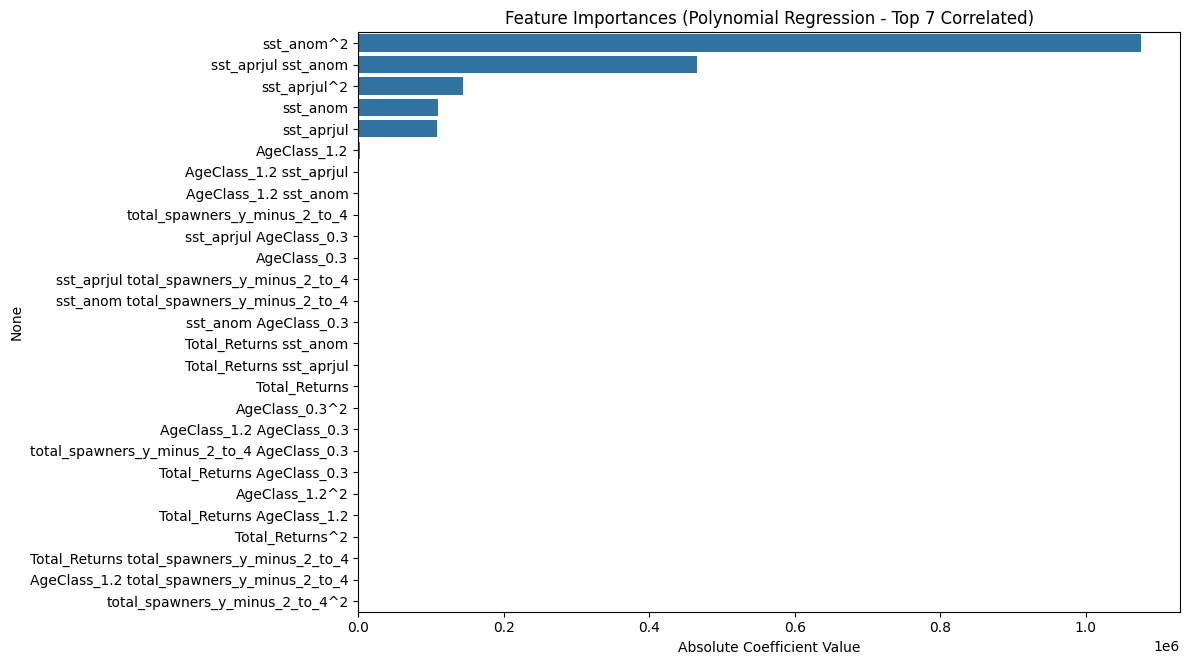

📊 Polynomial Regression Evaluation Metrics (Alagnak, Top 7 Features):
THIRD APPROACH - River Alagnak - TOP 10 FEATURES
🔹 R²   (train): 0.8513     | R²   (test): -114.1581
🔹 MSE  (train):  510058344061.21   | MSE  (test):  194236294991931.22
🔹 MAPE (train): 23.66%  | MAPE (test): 259.86%


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Filter only 'Alagnak' river
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 7 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top7_features = target_corr.abs().sort_values(ascending=False).head(7).index.tolist()

# Keep only top 7 + Year, River, and Target
columns_to_keep = top7_features + [col for col in ['Total_Returns_NextYear', 'Year', 'River'] if col not in top7_features]
df_alagnak = df_alagnak[columns_to_keep].sort_values(by='Year').reset_index(drop=True)

# === Step 3: Time-based train/test split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and targets ===
drop_columns = ['Total_Returns_NextYear', 'River', 'Year']
X_train = data_train.drop(columns=drop_columns).reset_index(drop=True)
y_train = data_train['Total_Returns_NextYear'].reset_index(drop=True)
X_test = data_test.drop(columns=drop_columns).reset_index(drop=True)
y_test = data_test['Total_Returns_NextYear'].reset_index(drop=True)

# === Step 5: Polynomial Features + Linear Regression ===
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

feature_names = poly.get_feature_names_out(X_train.columns)

model = LinearRegression()
model.fit(X_train_poly, y_train)

# === Step 6: Plot Coefficients ===
coefficients = pd.Series(model.coef_, index=feature_names)
top_features = coefficients.abs().sort_values(ascending=False)

plt.figure(figsize=(12, max(6, len(top_features) * 0.25)))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Polynomial Regression - Top 7 Correlated)")
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate (Train & Test) ===
y_pred_train = model.predict(X_train_poly)
y_pred_test = model.predict(X_test_poly)

# Métricas para treino
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

# Métricas para teste
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Impressão
print("📊 Polynomial Regression Evaluation Metrics (Alagnak, Top 7 Features):")
print("THIRD APPROACH - River Alagnak - TOP 10 FEATURES")
print(f"🔹 R²   (train): {r2_train:.4f}     | R²   (test): {r2_test:.4f}")
print(f"🔹 MSE  (train):  {mse_train:.2f}   | MSE  (test):  {mse_test:.2f}")
print(f"🔹 MAPE (train): {mape_train:.2f}%  | MAPE (test): {mape_test:.2f}%")


# Define result string
result_str = (
    "\n\n===============================\n"
    "THIRD APPROACH - TOP 10 FEATURES - Alagnak Only\n"
    "Polynomial Regression :\n"
    f"R²   (R-squared test):          {r2_test:.4f}\n"
    f"R²   (R-squared train):         {r2_train:.4f}\n"
    f"MSE  (Mean Squared Erro train):      {mse_train:.2f}\n"
    f"MSE  (Mean Squared Error test):      {mse_test:.2f}\n"
    f"MAPE (MAPE train):   {mape_train:.2f}%\n"
    f"MSE  (MAPE test):      {mape_test:.2f}\n"
)

# Path to results file
results_path = r"C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\results.txt"

# Append to file
with open(results_path, "a", encoding="utf-8") as f:
    f.write(result_str)

Linear Regression

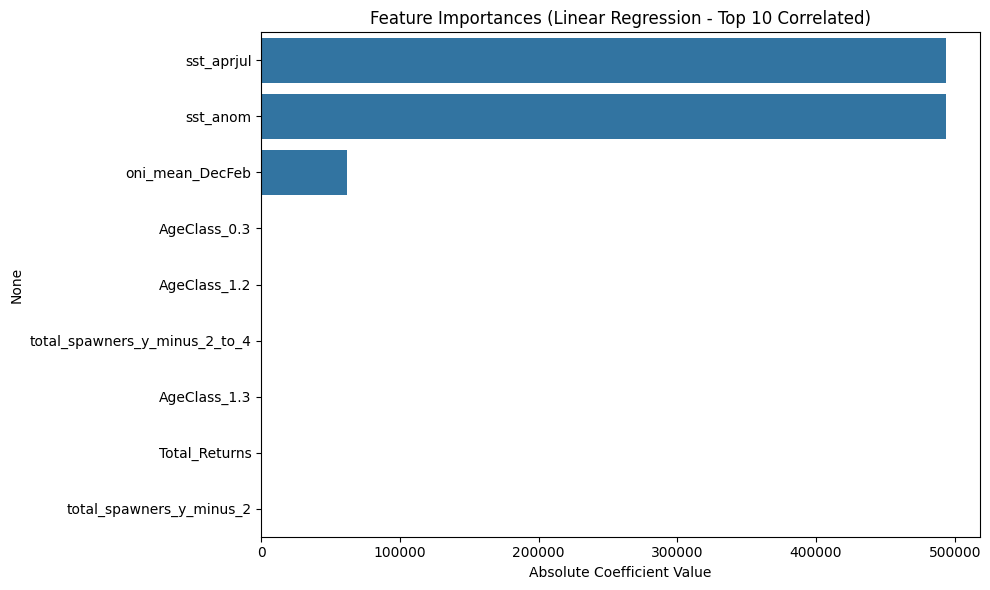

📊 Linear Regression Evaluation Metrics (Alagnak, Top 10 Features):
THIRD APPROACH - River Alagnak - TOP 10 FEATURES
🔹 R²   (train): 0.5115     | R²   (test): -0.9679
🔹 MSE  (train):  1675306344054.60   | MSE  (test):  3319289387160.84
🔹 MAPE (train): 45.11%  | MAPE (test): 51.13%


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Filter for 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 10 correlated features ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top10_features = target_corr.abs().sort_values(ascending=False).head(10).index.tolist()

# Force consistent column order and avoid duplication
columns_to_keep = top10_features + [col for col in ['Total_Returns_NextYear', 'Year', 'River'] if col not in top10_features]
df_alagnak = df_alagnak[columns_to_keep].sort_values(by='Year').reset_index(drop=True)

# === Step 3: Time-based train/test split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and target ===
drop_columns = ['Total_Returns_NextYear', 'River', 'Year']
X_train = data_train.drop(columns=drop_columns).reset_index(drop=True)
y_train = data_train['Total_Returns_NextYear'].reset_index(drop=True)
X_test = data_test.drop(columns=drop_columns).reset_index(drop=True)
y_test = data_test['Total_Returns_NextYear'].reset_index(drop=True)

# === Step 5: Train Linear Regression ===
model = LinearRegression()
model.fit(X_train, y_train)

# === Step 6: Plot Coefficients ===
coefficients = pd.Series(model.coef_, index=X_train.columns)
top_features = coefficients.abs().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Linear Regression - Top 10 Correlated)")
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate (Train & Test) ===
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Métricas para treino
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

# Métricas para teste
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Impressão formatada
print("📊 Linear Regression Evaluation Metrics (Alagnak, Top 10 Features):")
print("THIRD APPROACH - River Alagnak - TOP 10 FEATURES")
print(f"🔹 R²   (train): {r2_train:.4f}     | R²   (test): {r2_test:.4f}")
print(f"🔹 MSE  (train):  {mse_train:.2f}   | MSE  (test):  {mse_test:.2f}")
print(f"🔹 MAPE (train): {mape_train:.2f}%  | MAPE (test): {mape_test:.2f}%")

# Define result string
result_str = (
    "\n\n===============================\n"
    "THIRD APPROACH - TOP 10 FEATURES - Alagnak Only\n"
    "Linear Regression :\n"
    f"R²   (R-squared test):          {r2_test:.4f}\n"
    f"R²   (R-squared train):         {r2_train:.4f}\n"
    f"MSE  (Mean Squared Erro train):      {mse_train:.2f}\n"
    f"MSE  (Mean Squared Error test):      {mse_test:.2f}\n"
    f"MAPE (MAPE train):   {mape_train:.2f}%\n"
    f"MSE  (MAPE test):      {mape_test:.2f}\n"
)

# Path to results file
results_path = r"C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\results.txt"

# Append to file
with open(results_path, "a", encoding="utf-8") as f:
    f.write(result_str)


Random Forest model

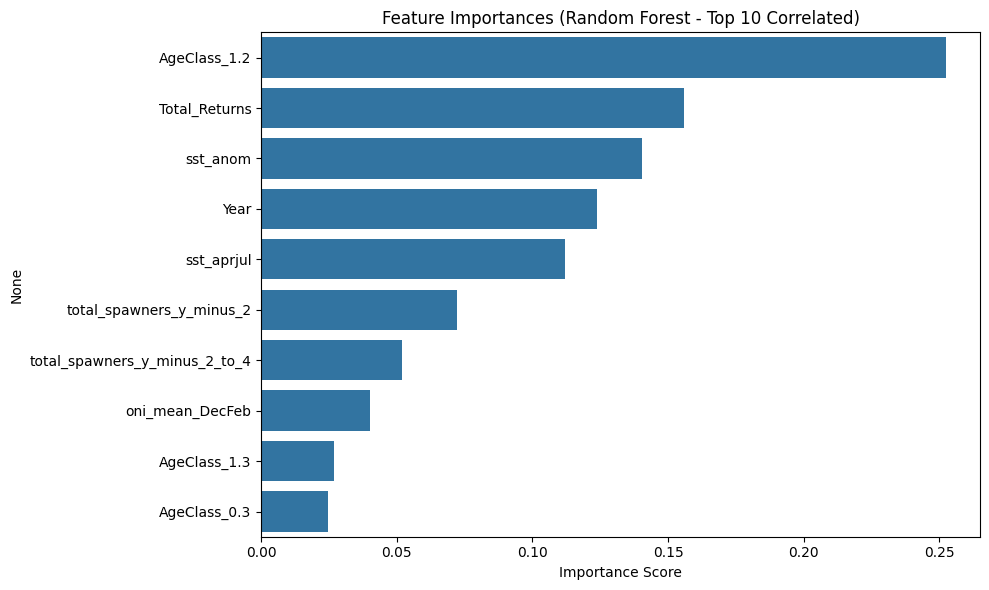

📊 Random Forest Evaluation Metrics (Alagnak, Top 10 Features):
THIRD APPROACH - River Alagnak - TOP 10 FEATURES
🔹 R²   (train): 0.9131     | R²   (test): -0.9224
🔹 MSE  (train):  298100666697.26   | MSE  (test):  3242429195245.71
🔹 MAPE (train): 19.70%  | MAPE (test): 53.73%


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Keep only rows where River is 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 10 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top10_features = target_corr.abs().sort_values(ascending=False).head(10).index.tolist()

# Ensure no duplicate 'Year' column
columns_to_keep = top10_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Define and apply time-series split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train = data_train['Total_Returns_NextYear']

X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Train Random Forest Regressor ===
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train)

# === Step 6: Feature Importances Plot ===
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Random Forest - Top 10 Correlated)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate (Train & Test) ===
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Métricas para treino
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

# Métricas para teste
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Impressão formatada
print("📊 Random Forest Evaluation Metrics (Alagnak, Top 10 Features):")
print("THIRD APPROACH - River Alagnak - TOP 10 FEATURES")
print(f"🔹 R²   (train): {r2_train:.4f}     | R²   (test): {r2_test:.4f}")
print(f"🔹 MSE  (train):  {mse_train:.2f}   | MSE  (test):  {mse_test:.2f}")
print(f"🔹 MAPE (train): {mape_train:.2f}%  | MAPE (test): {mape_test:.2f}%")

# Define result string
result_str = (
    "\n\n===============================\n"
    "THIRD APPROACH - TOP 10 FEATURES - Alagnak Only\n"
    "Random Forest :\n"
    f"R²   (R-squared test):          {r2_test:.4f}\n"
    f"R²   (R-squared train):         {r2_train:.4f}\n"
    f"MSE  (Mean Squared Erro train):      {mse_train:.2f}\n"
    f"MSE  (Mean Squared Error test):      {mse_test:.2f}\n"
    f"MAPE (MAPE train):   {mape_train:.2f}%\n"
    f"MSE  (MAPE test):      {mape_test:.2f}\n"
)

# Path to results file
results_path = r"C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\results.txt"

# Append to file
with open(results_path, "a", encoding="utf-8") as f:
    f.write(result_str)


Using the best model to predict 2023:

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tabulate import tabulate

# === Load data ===
file_path = r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
df = pd.read_csv(file_path)

# === Prepare results list ===
results = []

# === Loop through each river ===
for river in df['River'].unique():
    df_river = df[df['River'] == river].copy()

    # Ensure 2023 is available
    if 2023 not in df_river['Year'].values:
        print(f"Skipping {river} (no 2023 data)")
        continue

    # === Keep full feature set, then select top correlations AFTER ensuring original columns remain ===
    full_corr = df_river.corr(numeric_only=True)
    if 'Total_Returns_NextYear' not in full_corr.columns:
        print(f"Skipping {river} (no target correlation)")
        continue

    target_corr = full_corr['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
    top10 = target_corr.abs().sort_values(ascending=False).head(10).index.tolist()

    # Force keeping Year and River so we don’t lose structure
    selected_columns = top10 + [col for col in ['Total_Returns_NextYear', 'Year', 'River'] if col not in top10]

    df_river = df_river[selected_columns].copy()

    # Sort to make sure years are ordered
    df_river = df_river.sort_values(by='Year').reset_index(drop=True)

    # === Prepare train/test split ===
    train = df_river[df_river['Year'] <= 2022].copy().sort_values(by='Year').reset_index(drop=True)
    test = df_river[df_river['Year'] == 2023].copy().reset_index(drop=True)

    if train.empty or test.empty:
        print(f"Skipping {river} (empty train/test)")
        continue

    drop_cols = ['Total_Returns_NextYear', 'River', 'Year']
    X_train = train.drop(columns=drop_cols).reset_index(drop=True)
    y_train = train['Total_Returns_NextYear'].reset_index(drop=True)
    X_test = test.drop(columns=drop_cols).reset_index(drop=True)

    # === Train model ===
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)[0]

    # === Compare with actual ===
    actual = test['Total_Returns_NextYear'].values[0]
    error = abs(y_pred - actual)
    perc_error = (error / actual) * 100 if actual != 0 else np.nan

    results.append([
        river,
        f"{y_pred:,.0f}",
        f"{actual:,.0f}",
        f"{error:,.0f}",
        f"{perc_error:.2f}%"
    ])

# === Print final results table ===
headers = ["River", "Prediction (2023)", "Actual", "Absolute Error", "Percentage Error"]
print(tabulate(results, headers=headers, tablefmt="grid"))


+----------+---------------------+------------+------------------+--------------------+
| River    | Prediction (2023)   | Actual     | Absolute Error   | Percentage Error   |
+==========+=====================+============+==================+====================+
| Alagnak  | 2,135,212           | 4,335,435  | 2,200,223        | 50.75%             |
+----------+---------------------+------------+------------------+--------------------+
| Egegik   | 12,677,860          | 4,629,743  | 8,048,118        | 173.84%            |
+----------+---------------------+------------+------------------+--------------------+
| Igushik  | 1,161,339           | 1,572,250  | 410,911          | 26.14%             |
+----------+---------------------+------------+------------------+--------------------+
| Kvichak  | 8,012,143           | 12,207,053 | 4,194,910        | 34.36%             |
+----------+---------------------+------------+------------------+--------------------+
| Naknek   | 5,324,336          

In [7]:
data_set_bristol['River'].unique()

array(['Alagnak', 'Egegik', 'Igushik', 'Kvichak', 'Naknek', 'Nushagak',
       'Wood'], dtype=object)

****************************************************************************

Random Forest Updated Code with Log Transform on Target

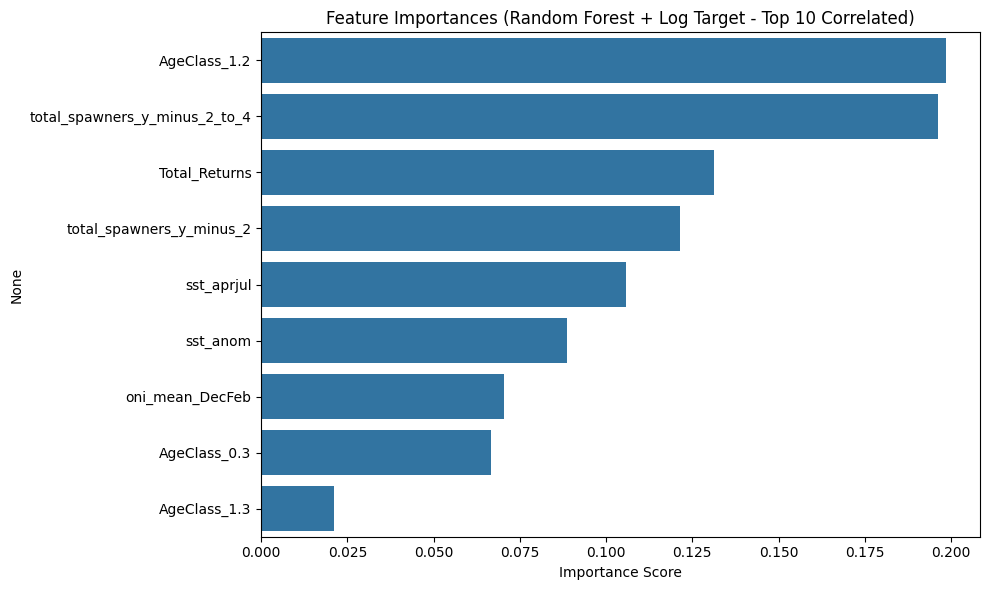

📊 Random Forest with Log-Transformed Target (Alagnak, Top 10 Features):
THIRD APPROACH - River Alagnak - TOP 10 FEATURES
🔹 R²   (train): 0.8789     | R²   (test): -0.3405
🔹 MSE  (train):  415356847287.73   | MSE  (test):  2260977569251.44
🔹 MAPE (train): 13.81%  | MAPE (test): 42.83%


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Filter only 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 10 correlated features ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top10_features = target_corr.abs().sort_values(ascending=False).head(10).index.tolist()

# Preserve column order and add essentials if missing
columns_to_keep = top10_features + [col for col in ['Total_Returns_NextYear', 'Year', 'River'] if col not in top10_features]
df_alagnak = df_alagnak[columns_to_keep].sort_values(by='Year').reset_index(drop=True)

# === Step 3: Time-based train/test split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and log-transformed target ===
drop_columns = ['Total_Returns_NextYear', 'River', 'Year']
X_train = data_train.drop(columns=drop_columns).reset_index(drop=True)
y_train_log = np.log1p(data_train['Total_Returns_NextYear']).reset_index(drop=True)

X_test = data_test.drop(columns=drop_columns).reset_index(drop=True)
y_test = data_test['Total_Returns_NextYear'].reset_index(drop=True)

# === Step 5: Train Random Forest ===
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train_log)

# === Step 6: Feature Importances ===
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Random Forest + Log Target - Top 10 Correlated)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 8: Evaluation (Train & Test with log reversal) ===
y_pred_log_train = rf.predict(X_train)
y_pred_train = np.expm1(y_pred_log_train)

y_pred_log_test = rf.predict(X_test)
y_pred_test = np.expm1(y_pred_log_test)

# Métricas de treino
r2_train = r2_score(np.expm1(y_train_log), y_pred_train)
mse_train = mean_squared_error(np.expm1(y_train_log), y_pred_train)
mape_train = np.mean(np.abs((np.expm1(y_train_log) - y_pred_train) / np.expm1(y_train_log))) * 100

# Métricas de teste
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Impressão formatada
print("📊 Random Forest with Log-Transformed Target (Alagnak, Top 10 Features):")
print("THIRD APPROACH - River Alagnak - TOP 10 FEATURES")
print(f"🔹 R²   (train): {r2_train:.4f}     | R²   (test): {r2_test:.4f}")
print(f"🔹 MSE  (train):  {mse_train:.2f}   | MSE  (test):  {mse_test:.2f}")
print(f"🔹 MAPE (train): {mape_train:.2f}%  | MAPE (test): {mape_test:.2f}%")

# Define result string
result_str = (
    "\n\n===============================\n"
    "THIRD APPROACH - TOP 10 FEATURES - Alagnak Only\n"
    "Random Forest with Log-Transformed Target  :\n"
    f"R²   (R-squared test):          {r2_test:.4f}\n"
    f"R²   (R-squared train):         {r2_train:.4f}\n"
    f"MSE  (Mean Squared Erro train):      {mse_train:.2f}\n"
    f"MSE  (Mean Squared Error test):      {mse_test:.2f}\n"
    f"MAPE (MAPE train):   {mape_train:.2f}%\n"
    f"MSE  (MAPE test):      {mape_test:.2f}\n"
)

# Path to results file
results_path = r"C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\results.txt"

# Append to file
with open(results_path, "a", encoding="utf-8") as f:
    f.write(result_str)


 Random Forest + Log-Transform + GridSearchCV (Alagnak only):

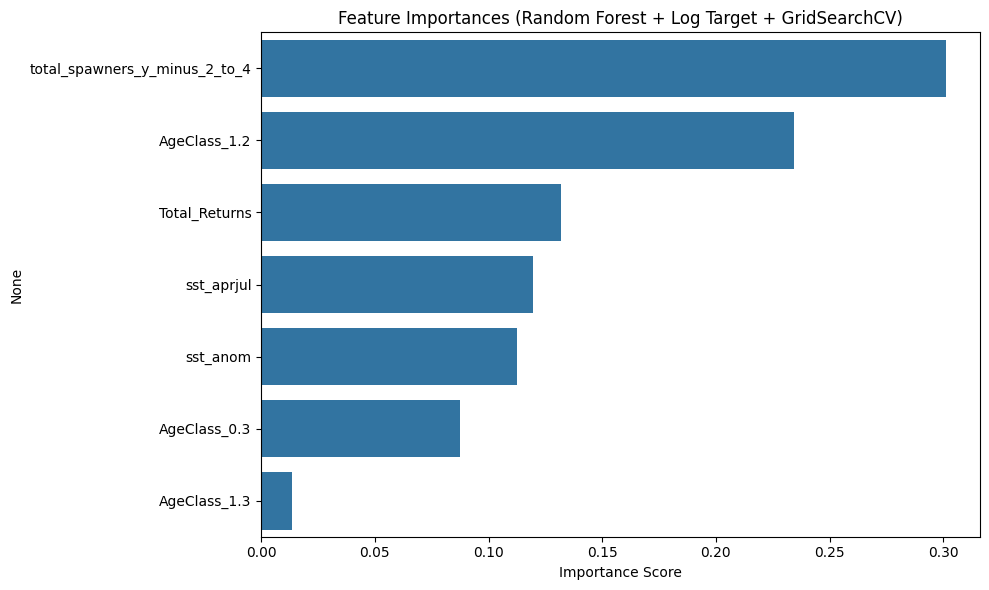

Random Forest + Log-Transformed Target + GridSearchCV (Alagnak, Top 8 Features):
THIRD APPROACH - River Alagnak - TOP 10 FEATURES
Best Params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
🔹 R²   (train): 0.7814     | R²   (test): -0.5752
🔹 MSE  (train):  749558640358.46   | MSE  (test):  2656905945978.65
🔹 MAPE (train): 19.53%  | MAPE (test): 46.67%


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Filter only 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 8 correlated features ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top8_features = target_corr.abs().sort_values(ascending=False).head(8).index.tolist()

# Keep consistent structure and sort by year
columns_to_keep = top8_features + [col for col in ['Total_Returns_NextYear', 'Year', 'River'] if col not in top8_features]
df_alagnak = df_alagnak[columns_to_keep].sort_values(by='Year').reset_index(drop=True)

# === Step 3: Time-based split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and log target ===
drop_columns = ['Total_Returns_NextYear', 'River', 'Year']
X_train = data_train.drop(columns=drop_columns).reset_index(drop=True)
y_train_log = np.log1p(data_train['Total_Returns_NextYear']).reset_index(drop=True)

X_test = data_test.drop(columns=drop_columns).reset_index(drop=True)
y_test = data_test['Total_Returns_NextYear'].reset_index(drop=True)

# === Step 5: GridSearchCV for Random Forest ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1
)
grid_search.fit(X_train, y_train_log)

best_rf = grid_search.best_estimator_

# === Step 6: Feature Importances ===
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Random Forest + Log Target + GridSearchCV)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 8: Evaluate (Train & Test with log reversal) ===
y_pred_log_train = best_rf.predict(X_train)
y_pred_train = np.expm1(y_pred_log_train)

y_pred_log_test = best_rf.predict(X_test)
y_pred_test = np.expm1(y_pred_log_test)

# Métricas de treino
r2_train = r2_score(np.expm1(y_train_log), y_pred_train)
mse_train = mean_squared_error(np.expm1(y_train_log), y_pred_train)
mape_train = np.mean(np.abs((np.expm1(y_train_log) - y_pred_train) / np.expm1(y_train_log))) * 100

# Métricas de teste
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# === Step 9: Report ===
print("Random Forest + Log-Transformed Target + GridSearchCV (Alagnak, Top 8 Features):")
print("THIRD APPROACH - River Alagnak - TOP 10 FEATURES")
print(f"Best Params: {grid_search.best_params_}")
print(f"🔹 R²   (train): {r2_train:.4f}     | R²   (test): {r2_test:.4f}")
print(f"🔹 MSE  (train):  {mse_train:.2f}   | MSE  (test):  {mse_test:.2f}")
print(f"🔹 MAPE (train): {mape_train:.2f}%  | MAPE (test): {mape_test:.2f}%")

# Define result string
result_str = (
    "\n\n===============================\n"
    "THIRD APPROACH - TOP 10 FEATURES - Alagnak Only\n"
    "Random Forest + Log-Transformed Target + GridSearchCV  :\n"
    f"R²   (R-squared test):          {r2_test:.4f}\n"
    f"R²   (R-squared train):         {r2_train:.4f}\n"
    f"MSE  (Mean Squared Erro train):      {mse_train:.2f}\n"
    f"MSE  (Mean Squared Error test):      {mse_test:.2f}\n"
    f"MAPE (MAPE train):   {mape_train:.2f}%\n"
    f"MSE  (MAPE test):      {mape_test:.2f}\n"
)

# Path to results file
results_path = r"C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\results.txt"

# Append to file
with open(results_path, "a", encoding="utf-8") as f:
    f.write(result_str)



XGBoost Regressor

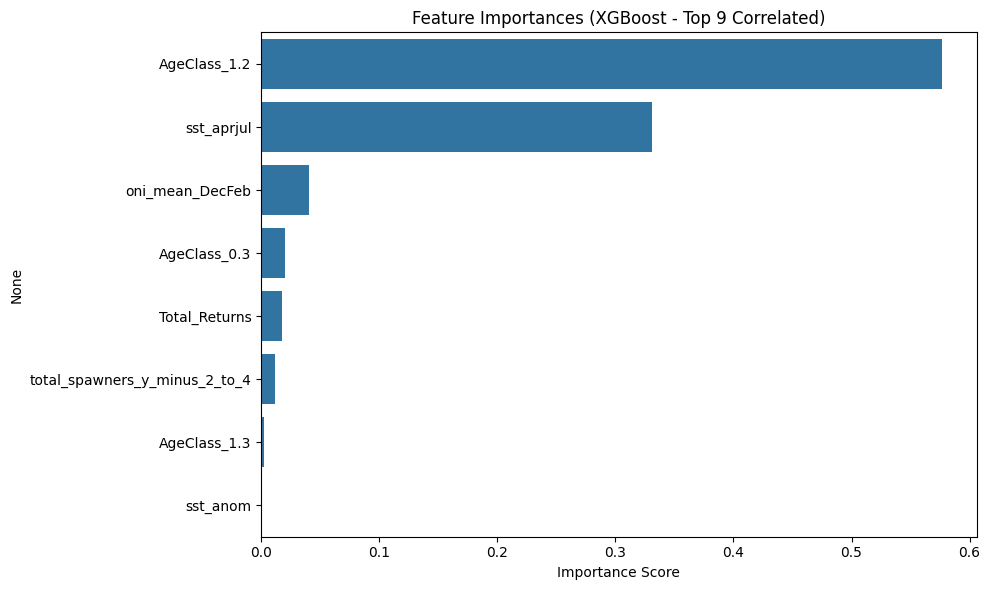

XGBoost Evaluation Metrics (Alagnak, Top 9 Features):
THIRD APPROACH - River Alagnak - TOP 10 FEATURES
🔹 R²   (train): 1.0000     | R²   (test): -3.8437
🔹 MSE  (train):  0.13   | MSE  (test):  8169792995392.21
🔹 MAPE (train): 0.00%  | MAPE (test): 82.54%


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Filter only 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 9 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top9_features = target_corr.abs().sort_values(ascending=False).head(9).index.tolist()

# Keep top 9 + target + Year + River (preserving order and avoiding duplicates)
columns_to_keep = top9_features + [col for col in ['Total_Returns_NextYear', 'Year', 'River'] if col not in top9_features]
df_alagnak = df_alagnak[columns_to_keep].sort_values(by='Year').reset_index(drop=True)

# === Step 3: Time-based train/test split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and target ===
drop_columns = ['Total_Returns_NextYear', 'River', 'Year']
X_train = data_train.drop(columns=drop_columns).reset_index(drop=True)
y_train = data_train['Total_Returns_NextYear'].reset_index(drop=True)

X_test = data_test.drop(columns=drop_columns).reset_index(drop=True)
y_test = data_test['Total_Returns_NextYear'].reset_index(drop=True)

# === Step 5: Train XGBoost Regressor ===
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# === Step 6: Feature Importances ===
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (XGBoost - Top 9 Correlated)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate (Train and Test separately) ===
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Métricas de treino
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

# Métricas de teste
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("XGBoost Evaluation Metrics (Alagnak, Top 9 Features):")
print("THIRD APPROACH - River Alagnak - TOP 10 FEATURES")
print(f"🔹 R²   (train): {r2_train:.4f}     | R²   (test): {r2_test:.4f}")
print(f"🔹 MSE  (train):  {mse_train:.2f}   | MSE  (test):  {mse_test:.2f}")
print(f"🔹 MAPE (train): {mape_train:.2f}%  | MAPE (test): {mape_test:.2f}%")

# Define result string
result_str = (
    "\n\n===============================\n"
    "THIRD APPROACH - TOP 10 FEATURES - Alagnak Only\n"
    "XGBoost  :\n"
    f"R²   (R-squared test):          {r2_test:.4f}\n"
    f"R²   (R-squared train):         {r2_train:.4f}\n"
    f"MSE  (Mean Squared Erro train):      {mse_train:.2f}\n"
    f"MSE  (Mean Squared Error test):      {mse_test:.2f}\n"
    f"MAPE (MAPE train):   {mape_train:.2f}%\n"
    f"MSE  (MAPE test):      {mape_test:.2f}\n"
)

# Path to results file
results_path = r"C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\results.txt"

# Append to file
with open(results_path, "a", encoding="utf-8") as f:
    f.write(result_str)

